In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import pickle
import re
from bs4 import BeautifulSoup
from sys import stdout

# Relatives analysis

**In this notebook, we are only interested in the links created between characters that are relatives. We will build an adjacency matrix based on that.**

# Part 1: Marvel dataset

In [2]:
with open('data/clean_marvel.txt', 'rb') as f:
    relat_marvel = pickle.load(f)

relat_marvel.drop(columns=['Relatives'], inplace=True)

relat_marvel

,URL,Real Name,Current Alias,Affiliation
0,/wiki/Aaron_Fox_(Earth-616),Aaron Fox,Unknown,[]
1,/wiki/Acrobat_(1940s)_(Earth-616),Unknown,Acrobat,[]
2,/wiki/Abigail_Mercury_(Clone)_(Earth-616),Abigail Mercury,Unknown,[]
3,/wiki/Ace_Maxwell_(Earth-616),Ace Maxwell,Unknown,[]
4,/wiki/Abigail_Boylen_(Earth-616),"Abigail ""Abby"" Boylen",Cloud 9,"[/wiki/Champions_(Earth-616), /wiki/Undergroun..."
...,...,...,...,...
28034,/wiki/Zxaxz_(Earth-616),Zxaxz,Unknown,[]
28035,/wiki/Zuwena_(Earth-616),Zuwena,Unknown,[/wiki/Elephant%27s_Trunk_(Earth-616)]
28036,/wiki/Zurvan_(Earth-616),Zurvan,Unknown,[]
28037,/wiki/Zygo_(Earth-616),Zygo,General Zygo,[]


**We split the list in the column `Relatives`, each URL that is in it will be in a different row, with the corresponding character.**

In [3]:
s = relat_marvel.apply(lambda x: pd.Series(x['Relatives']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Relatives'

relat_marvel = relat_marvel.drop('Relatives', axis=1).join(s)
relat_marvel['Relatives'] = pd.Series(relat_marvel['Relatives'], dtype=object)
relat_marvel

,URL,Real Name,Current Alias,Relatives
0,/wiki/Aaron_Fox_(Earth-616),Aaron Fox,Unknown,/wiki/Beth_Fox_(Earth-616)
1,/wiki/Acrobat_(1940s)_(Earth-616),Unknown,Acrobat,
2,/wiki/Abigail_Mercury_(Clone)_(Earth-616),Abigail Mercury,Unknown,/wiki/Abigail_Mercury_(Earth-616)
3,/wiki/Ace_Maxwell_(Earth-616),Ace Maxwell,Unknown,
4,/wiki/Abigail_Boylen_(Earth-616),"Abigail ""Abby"" Boylen",Cloud 9,#cite_note-Avengers_The_Initiative_Vol_1_1-2
...,...,...,...,...
28036,/wiki/Zurvan_(Earth-616),Zurvan,Unknown,/wiki/Ahura_Mazda_(Earth-616)
28036,/wiki/Zurvan_(Earth-616),Zurvan,Unknown,/wiki/Ahriman_(Earth-616)
28036,/wiki/Zurvan_(Earth-616),Zurvan,Unknown,#cite_note-.0A.3B_The_.5B.5BYazatas.5D.5D.27_e...
28037,/wiki/Zygo_(Earth-616),Zygo,General Zygo,


**We create a list of unique urls, and use it as rows and columns of the adjacency matrix.**

In [4]:
urls = relat_marvel['URL'].unique()
adj_relat_marvel = pd.DataFrame(0, index=urls, columns=urls)

**Some URLs aren't stored the same way in the `Relatives` as in the `URL`. For example, we could have */wiki/Buri_(Asgardian)_(Earth-616)* in `Relatives` and */wiki/Buri_(Earth-616)* in `URL`, even if they link to the same page. We thus use a request and get the URL again to match the two columns.**

In [5]:
i = 0
tot_page = 28039

for url in urls:
    # Loading bar
    i += 1
    printed= i/tot_page*100
    stdout.write("\r%f %%" % printed)
    stdout.flush()
    
    for rel in relat_marvel[relat_marvel['URL'] == url]['Relatives']:
        # Deal with different URLs
        if rel not in urls:
            r = requests.get('https://marvel.fandom.com' + rel)
            if r:
                rel = r.url.replace('https://marvel.fandom.com','')
            
        #All URLs in the adjacency start with "/wiki"
        if (rel is not '') and ('/wiki/' in rel):
            if rel[0] is not '/':
                rel = rel[1:]
            if rel in urls:
                adj_relat_marvel[url][rel] = 1
                
                # Adjacency should be symmetric. Even if some data is missing for a character,
                # we make sure that we fill in the matrix correctly.
                adj_relat_marvel[rel][url] = 1

100.000000 %

In [13]:
adj_relat_marvel

,/wiki/Aaron_Fox_(Earth-616),/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Abigail_Mercury_(Clone)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/Abigail_Boylen_(Earth-616),/wiki/Abarac_(Earth-616),/wiki/Abner_Perry_(Earth-616),/wiki/Abdul_Qamar_(Earth-616),/wiki/Aaron_Verne_(Earth-616),/wiki/Abner_Doolittle_(Earth-616),...,/wiki/Zyziwc_Tiel_(Earth-616),/wiki/Zuzha_Yu_(Earth-616),/wiki/Zula_(Earth-616),/wiki/Zzzyclone_(Warp_World)_(Earth-616),/wiki/Zuhn_(Earth-616),/wiki/Zxaxz_(Earth-616),/wiki/Zuwena_(Earth-616),/wiki/Zurvan_(Earth-616),/wiki/Zygo_(Earth-616),/wiki/%C3%84kr%C3%A4s_(Earth-616)
/wiki/Aaron_Fox_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Acrobat_(1940s)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Mercury_(Clone)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Boylen_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zxaxz_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zuwena_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zurvan_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zygo_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
pickle.dump(adj_relat_marvel, open("data/adj_relat_marvel.txt", 'wb'), protocol=4)

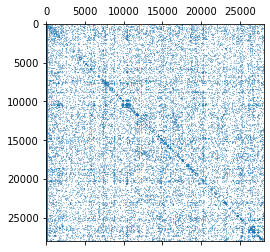

In [55]:
plt.spy(adj_relat_marvel,markersize=0.1)

In [28]:
dum = adj_relat_marvel

In [48]:
adj_relat_marvel['/wiki/Ace_Maxwell_(Earth-616)']

/wiki/Aaron_Fox_(Earth-616)                  1
/wiki/Acrobat_(1940s)_(Earth-616)            1
/wiki/Abigail_Mercury_(Clone)_(Earth-616)    1
/wiki/Ace_Maxwell_(Earth-616)                1
/wiki/Abigail_Boylen_(Earth-616)             1
                                            ..
/wiki/Zxaxz_(Earth-616)                      1
/wiki/Zuwena_(Earth-616)                     1
/wiki/Zurvan_(Earth-616)                     1
/wiki/Zygo_(Earth-616)                       1
/wiki/%C3%84kr%C3%A4s_(Earth-616)            1
Name: /wiki/Ace_Maxwell_(Earth-616), Length: 28039, dtype: int64

In [43]:
dum

,/wiki/Aaron_Fox_(Earth-616),/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Abigail_Mercury_(Clone)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/Abigail_Boylen_(Earth-616),/wiki/Abarac_(Earth-616),/wiki/Abner_Perry_(Earth-616),/wiki/Abdul_Qamar_(Earth-616),/wiki/Aaron_Verne_(Earth-616),/wiki/Abner_Doolittle_(Earth-616),...,/wiki/Zyziwc_Tiel_(Earth-616),/wiki/Zuzha_Yu_(Earth-616),/wiki/Zula_(Earth-616),/wiki/Zzzyclone_(Warp_World)_(Earth-616),/wiki/Zuhn_(Earth-616),/wiki/Zxaxz_(Earth-616),/wiki/Zuwena_(Earth-616),/wiki/Zurvan_(Earth-616),/wiki/Zygo_(Earth-616),/wiki/%C3%84kr%C3%A4s_(Earth-616)
/wiki/Aaron_Fox_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Acrobat_(1940s)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Mercury_(Clone)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Boylen_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zxaxz_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zuwena_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zurvan_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zygo_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 2: DC dataset

In [56]:
with open('data/clean_dc.txt', 'rb') as f:
    relat_dc = pickle.load(f)

relat_dc.drop(columns=['Affiliation'], inplace=True)

relat_dc

,URL,Real Name,Current Alias,Relatives
0,/wiki/Aaron_Hayley_(New_Earth),Aaron Hayley,Swamp Thing,[]
1,/wiki/Abigail_Fine_(Smallville),Abigail Fine,Abigail Fine,[/wiki/Elise_Fine_(Smallville)]
2,/wiki/Adam_Strange_(JSA:_The_Golden_Age),Adam Strange,Adam Strange,[]
3,/wiki/Alan_Barnes_(New_Earth),Alan Barnes,Brainstorm,[]
4,/wiki/Alan_Scott_(Earth_2),Alan Scott,Green Lantern,[/wiki/Sam_Zhao_(Earth_2)]
...,...,...,...,...
10472,/wiki/Zeta_(Earth-One),Unknown,Zeta,[]
10473,/wiki/Zotan_(Earth-S),Zotan,Zotan,[]
10474,/wiki/Zond_(Earth-One),Zond,Zond the Sorcerer,[]
10475,/wiki/Zora_Vi-Lar_(Earth-One),Zora Vi-Lar,Black Flame,[]


**We split the list in the column `Relatives`, each URL that is in it will be in a different row, with the corresponding character.**

In [57]:
s = relat_dc.apply(lambda x: pd.Series(x['Relatives']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Relatives'

relat_dc = relat_dc.drop('Relatives', axis=1).join(s)
relat_dc['Relatives'] = pd.Series(relat_dc['Relatives'], dtype=object)
relat_dc

,URL,Real Name,Current Alias,Relatives
0,/wiki/Aaron_Hayley_(New_Earth),Aaron Hayley,Swamp Thing,
0,/wiki/Aaron_Hayley_(New_Earth),Aaron Hayley,Swamp Thing,
0,/wiki/Albert_Rothstein_(Arrow:_Earth-2),Albert Rothstein,Atom Smasher,
0,/wiki/Albert_Rothstein_(Arrow:_Earth-2),Albert Rothstein,Atom Smasher,
1,/wiki/Abigail_Fine_(Smallville),Abigail Fine,Abigail Fine,/wiki/Elise_Fine_(Smallville)
...,...,...,...,...
11845,/wiki/Zor-El_(Arrow:_Earth-38),Zor-El,Unknown,/wiki/Astra_In-Ze_(Arrow:_Earth-38)
11845,/wiki/Zor-El_(Arrow:_Earth-38),Zor-El,Unknown,/wiki/Jor-El_(Arrow:_Earth-38)
11845,/wiki/Zor-El_(Arrow:_Earth-38),Zor-El,Unknown,/wiki/Lara_Lor-Van_(Arrow:_Earth-38)
11845,/wiki/Zor-El_(Arrow:_Earth-38),Zor-El,Unknown,/wiki/Non_(Arrow:_Earth-38)


**We create a list of unique urls, and use it as rows and columns of the adjacency matrix.**

In [83]:
urls = relat_dc['URL'].unique()
adj_relat_dc = pd.DataFrame(0, index=urls, columns=urls)

**As for Marvel, some URLs aren't stored the same way in the `Relatives` as in the `URL`. We also use a request to get the URL that matches the two columns.**

In [84]:
i = 0
tot_page = 22323

for url in urls:
    # Loading bar
    i += 1
    printed= i/tot_page*100
    stdout.write("\r%f %%" % printed)
    stdout.flush()
    
    for rel in relat_dc[relat_dc['URL'] == url]['Relatives']:
        # Deal with different URLs
        if rel not in urls:
            try:
                r = requests.get('https://dc.fandom.com' + rel)
                if r:
                    rel = r.url.replace('https://dc.fandom.com','')
            except:
                rel = ''
            
        #All URLs in the adjacency start with "/wiki"
        if (rel is not '') and ('/wiki/' in rel):
            if rel[0] is not '/':
                rel = rel[1:]
            if rel in urls:
                adj_relat_dc[url][rel] = 1
                
                # Adjacency should be symmetric. Even if some data is missing for a character,
                # we make sure that we fill in the matrix correctly.
                adj_relat_dc[rel][url] = 1

99.991041 %

In [85]:
pickle.dump(adj_relat_dc, open("data/adj_relat_dc.txt", 'wb'), protocol=4)

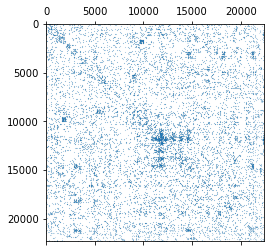

In [88]:
plt.spy(adj_relat_dc,markersize=0.05)